# Desa SPOT 10m ES Compare

Pada proses clipping citra , ditemukan 577 desa dengan tutupan awan tinggi untuk satelit SPOT 6-7 seperti yang dapat dilihat pada Gambar 6. Sehingga pada kajian efek resolusi citra terhadap model akan dilakukan pada 5380 desa dan 200.200 SLS.

Dari hasil sebelumnya, dapat dilihat densenet121 adalah model terbaik untuk mengklasfikari desa urban dan rural dengan model data : SLS dan Square Neighbour. Skenario tersebut akan digunakan untuk menguji efek resolusi terhadap klasifikasi dengan melakukan train terhadapa uncovered desa baik dengan data sentinel maupun spot.

Pada bagian ini dilakukan pemodelan untuk SPOT dentan tingkat desa.

In [1]:
import fastai
from fastai.vision.all import *
import os
from PIL import Image
import pandas as pd
import shutil
import torch

In [2]:
torch.cuda.get_device_name(0)

'NVIDIA GeForce RTX 3050 Laptop GPU'

#### Preprocessing

In [3]:
idm = pd.read_csv("C:/Users/jwst2/Python/tesis/dataset/newdata_edit.csv")

In [4]:
idm = idm.drop_duplicates("bps_kelurahan_kode")

In [5]:
idm.groupby("status").count()

,kemendagri_kelurahan_kode,bps_kelurahan_kode,bps_kelurahan_nama,kemendagri_kelurahan_nama,id,kemendagri_provinsi_kode,kemendagri_kota_kode,kemendagri_kecamatan_kode,kemendagri_provinsi_nama,kemendagri_kota_nama,...,status_adm,nama,id_kecamatan,nama_kecamatan,id_kabupaten,nama_kabupaten,iks,ike,ikl,avg_idm
status,,,,,,,,,,,,,,,,,,,,,
BERKEMBANG,3290,3290,3223,3290,3290,3290,3290,3290,3290,3290,...,0,3290,3290,3290,3290,3290,3290,3290,3290,3290
MAJU,1631,1631,1584,1631,1631,1631,1631,1631,1631,1631,...,0,1631,1631,1631,1631,1631,1631,1631,1631,1631
MANDIRI,270,270,267,270,270,270,270,270,270,270,...,0,270,270,270,270,270,270,270,270,270
TERTINGGAL,121,121,119,121,121,121,121,121,121,121,...,0,121,121,121,121,121,121,121,121,121


In [6]:
idm[idm.bps_kelurahan_kode ==3209100011]

,kemendagri_kelurahan_kode,bps_kelurahan_kode,status,bps_kelurahan_nama,kemendagri_kelurahan_nama,id,kemendagri_provinsi_kode,kemendagri_kota_kode,kemendagri_kecamatan_kode,kemendagri_provinsi_nama,...,status_adm,nama,id_kecamatan,nama_kecamatan,id_kabupaten,nama_kabupaten,iks,ike,ikl,avg_idm
3070,3209132011,3.209100e+09,MAJU,NaN,BEBER,3038,32,32.09,32.09.13,JAWA BARAT,...,NaN,BEBER,320913.0,BEBER,3209.0,KABUPATEN CIREBON,0.8629,0.8,0.6667,0.7765


In [7]:
3290+1631+270+121

5312

In [8]:
yourpath = "C:/Users/jwst2/Python/tesis/jpg/general desa spot ES/"
destpath = 'C:/Users/jwst2/Python/tesis/jpg/IDM/08. Desa SPOT 10m ES RES'

In [9]:
os.chdir(destpath)
if os.path.isdir('MAJU') is False:
    os.makedirs('MAJU MANDIRI')
    os.makedirs('TERTINGGAL BERKEMBANG')


In [10]:

from tqdm import tqdm
for root, dirs, files in tqdm(os.walk(yourpath, topdown=False)):
    for name in files:
        if(not idm.status[idm.bps_kelurahan_kode == int(name.replace(".jpg",""))].empty):
            if(idm.status[idm.bps_kelurahan_kode == int(name.replace(".jpg",""))].iloc[0] == "MAJU"):
                shutil.copy(os.path.join(root, name), destpath+"/MAJU MANDIRI/"+name)
            elif(idm.status[idm.bps_kelurahan_kode == int(name.replace(".jpg",""))].iloc[0] == "BERKEMBANG"):
                shutil.copy(os.path.join(root, name), destpath+"/TERTINGGAL BERKEMBANG/"+name)
            elif(idm.status[idm.bps_kelurahan_kode == int(name.replace(".jpg",""))].iloc[0] == "TERTINGGAL"):
                shutil.copy(os.path.join(root, name), destpath+"/TERTINGGAL BERKEMBANG/"+name)
            elif(idm.status[idm.bps_kelurahan_kode == int(name.replace(".jpg",""))].iloc[0] == "MANDIRI"):
                shutil.copy(os.path.join(root, name), destpath+"/MAJU MANDIRI/"+name)
       

1it [00:18, 18.64s/it]


In [11]:
1750+3052

4802

#### Models

In [9]:
path = Path.cwd() / (destpath)

In [10]:
Path.BASE_PATH = path
path.ls()

(#3) [Path('MAJU MANDIRI'),Path('models'),Path('TERTINGGAL BERKEMBANG')]

In [11]:
fname = (path/"TERTINGGAL BERKEMBANG").ls()[0]
fname

Path('TERTINGGAL BERKEMBANG/3201010001.jpg')

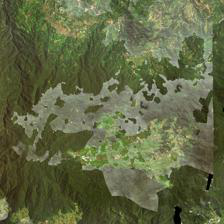

In [12]:
img = Image.open(fname)
img

In [13]:
blocks = DataBlock(blocks = (ImageBlock, CategoryBlock),
                 get_items=get_image_files, # finds the images in the path
                 splitter=RandomSplitter(0.1,seed=42),  # default random split 80% training, 20% validation
                 get_y=parent_label,
                 item_tfms = Resize(224)) # data augmentation (mult multiplies the default transformation values)

In [14]:
dls = blocks.dataloaders(path,bs= 10)

Due to IPython and Windows limitation, python multiprocessing isn't available now.
So `number_workers` is changed to 0 to avoid getting stuck


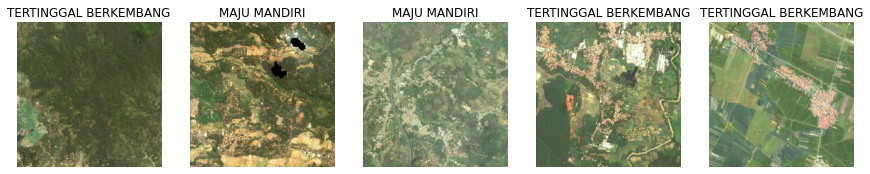

In [15]:
dls.show_batch(nrows=1, ncols=5)

#### Densenet

In [28]:
avg = 'macro'
roca = RocAucBinary(average=avg)
f1s = F1Score(average=avg)
bc = BalancedAccuracy()
metrics=[accuracy,bc, Precision(average=avg), Recall(average=avg), f1s,roca]

In [29]:
learn = cnn_learner(dls, densenet121, metrics=metrics) 

SuggestedLRs(valley=9.999999747378752e-06)

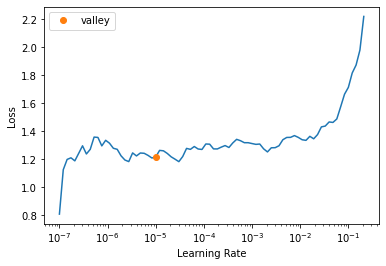

In [22]:
learn.lr_find()

In [30]:
learn.fit_one_cycle(7, lr_max = 1e-4)

epoch,train_loss,valid_loss,accuracy,balanced_accuracy_score,precision_score,recall_score,f1_score,roc_auc_score,time
0,1.186005,0.927536,0.541667,0.582263,0.581111,0.582263,0.541595,0.610416,01:57
1,0.918311,0.760769,0.604167,0.574262,0.573555,0.574262,0.573864,0.624239,01:52
2,0.910020,0.694997,0.641667,0.624746,0.619710,0.624746,0.621034,0.673278,01:53
3,0.847195,0.771023,0.652083,0.611844,0.618213,0.611844,0.613871,0.638438,01:56
4,0.705633,0.688504,0.660417,0.605984,0.623428,0.605984,0.608359,0.664488,01:57
5,0.682251,0.695781,0.639583,0.602040,0.605785,0.602040,0.603391,0.662309,01:57
6,0.683674,0.695187,0.675000,0.616182,0.641634,0.616182,0.619017,0.664131,01:57


C:\Users\jwst2\anaconda3\envs\datasc\lib\site-packages\PIL\Image.py:2896: DecompressionBombWarning: Image size (170250304 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(
C:\Users\jwst2\anaconda3\envs\datasc\lib\site-packages\PIL\Image.py:2896: DecompressionBombWarning: Image size (170250304 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(
C:\Users\jwst2\anaconda3\envs\datasc\lib\site-packages\PIL\Image.py:2896: DecompressionBombWarning: Image size (170250304 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(
C:\Users\jwst2\anaconda3\envs\datasc\lib\site-packages\PIL\Image.py:2896: DecompressionBombWarning: Image size (170250304 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(
C:\Users\jwst2\anaconda3\envs\datasc\lib\site-packages\PIL\Image.py:2896: DecompressionBombWarning: Image size (1702

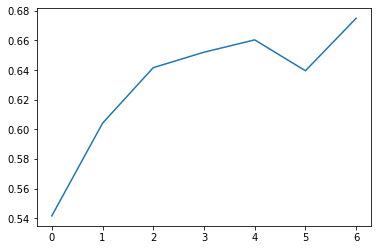

In [31]:
plt.plot(L(learn.recorder.values).itemgot(2));

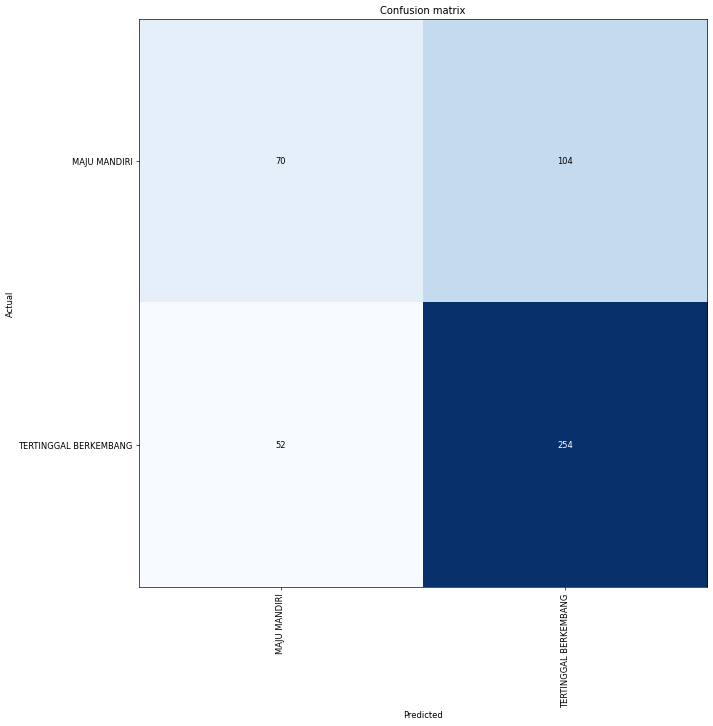

In [32]:
interp = ClassificationInterpretation.from_learner(learn)
interp.plot_confusion_matrix(figsize=(12,12), dpi=60)

In [ ]:
interp.plot_top_losses(6, figsize=(15,11))

In [34]:
learn.export('C:/Users/jwst2/Python/tesis/idm/models/Desa densenet sentinel 10m ES RES.pkl')